In [1]:
# !pip3 install -U ucimlrepo

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [3]:
# Fetch data
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Preprocess data
means = X.mean()
X = X.fillna(means)
X = pd.get_dummies(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
X_val_tensor = torch.tensor(X_val.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32)).view(-1, 1)
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# Create DataLoaders
batch_size = 64  # Same as TensorFlow
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [4]:
# Define model
class DiabetesPredictor(nn.Module):
    def __init__(self, input_features):
        super(DiabetesPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_features, 256),  # Changed from 512 to match TensorFlow
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),  # Changed from 512 to match TensorFlow
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

input_features = X_train.shape[1]
model = DiabetesPredictor(input_features)

In [5]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss_accum = []  # List to store losses of each batch

    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_accum.append(loss.item())  # Append the loss of the current batch

    # Compute average training loss for the epoch and store it
    epoch_train_loss = np.mean(train_loss_accum)
    train_losses.append(epoch_train_loss)

    # Compute validation loss for the epoch and store it
    model.eval()
    with torch.no_grad():
        val_loss_accum = []  # List to store validation losses
        for data, labels in val_loader:
            outputs = model(data)
            val_loss = criterion(outputs, labels)
            val_loss_accum.append(val_loss.item())

        epoch_val_loss = np.mean(val_loss_accum)
        val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

Epoch 1, Train Loss: 0.3464, Validation Loss: 0.3163
Epoch 2, Train Loss: 0.3201, Validation Loss: 0.3125
Epoch 3, Train Loss: 0.3189, Validation Loss: 0.3134
Epoch 4, Train Loss: 0.3183, Validation Loss: 0.3146
Epoch 5, Train Loss: 0.3177, Validation Loss: 0.3120
Epoch 6, Train Loss: 0.3171, Validation Loss: 0.3127
Epoch 7, Train Loss: 0.3174, Validation Loss: 0.3123
Epoch 8, Train Loss: 0.3165, Validation Loss: 0.3113
Epoch 9, Train Loss: 0.3163, Validation Loss: 0.3120
Epoch 10, Train Loss: 0.3160, Validation Loss: 0.3126
Epoch 11, Train Loss: 0.3157, Validation Loss: 0.3117
Epoch 12, Train Loss: 0.3158, Validation Loss: 0.3115
Epoch 13, Train Loss: 0.3156, Validation Loss: 0.3113
Epoch 14, Train Loss: 0.3154, Validation Loss: 0.3118
Epoch 15, Train Loss: 0.3151, Validation Loss: 0.3136
Epoch 16, Train Loss: 0.3149, Validation Loss: 0.3119
Epoch 17, Train Loss: 0.3148, Validation Loss: 0.3117
Epoch 18, Train Loss: 0.3151, Validation Loss: 0.3127
Epoch 19, Train Loss: 0.3144, Validat

In [6]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Evaluate the model on the test dataset to get loss and accuracy
model.eval()
test_losses = []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        # Calculate accuracy
        predicted = outputs > 0.5  # Applying the default threshold of 0.5 for binary classification
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = np.mean(test_losses)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# To predict and apply a custom threshold of 0.54 for binary classification
with torch.no_grad():
    y_pred_probs = model(X_test_tensor.to(device))
y_pred = (y_pred_probs > 0.65).int()  # Applying a threshold

# Calculate accuracy using sklearn's accuracy_score for comparison
custom_accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.cpu().numpy())
print(f"Custom Threshold Accuracy: {custom_accuracy:.4f}")

cpu
Test Loss: 0.3109
Test Accuracy: 0.8667
Custom Threshold Accuracy: 0.8651


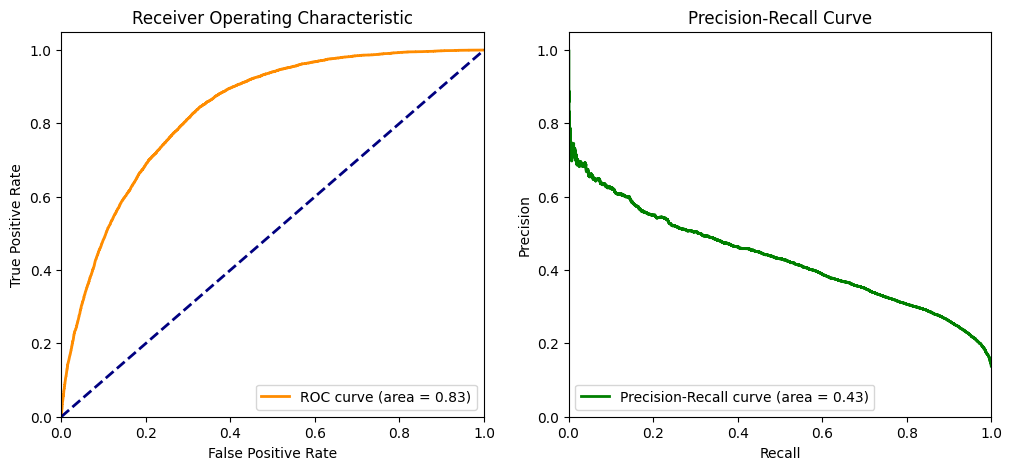

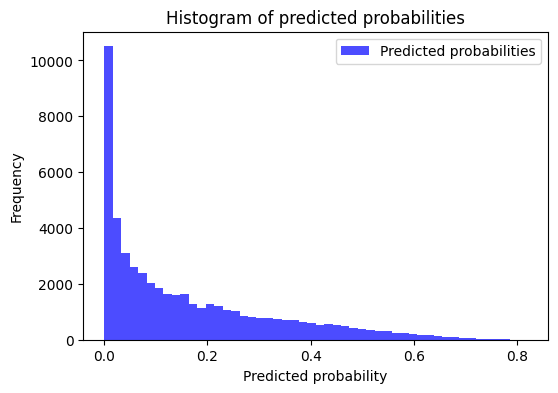

In [7]:
# Compute ROC curve and ROC area
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
pr_auc = average_precision_score(y_test, y_pred_probs)

# Plotting the ROC Curve and Precision-Recall Curve
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC.png')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('PRC.png')

plt.show()

# Plotting histogram of predicted probabilities
plt.figure(figsize=(6, 4))
plt.hist(y_pred_probs, bins=50, color='blue', alpha=0.7, label='Predicted probabilities')
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')
plt.savefig('Histogram of predicted probabilities.png')
plt.legend()
plt.show()

In [8]:
# Test loop
test_losses = []
model.eval()
with torch.no_grad():
    for batch_index, (batch_x, batch_y) in enumerate(test_loader):
        if batch_index % 20 == 0:  # Check if the current batch index is a multiple of 20
            preds = model(batch_x)  # Get predictions
            loss = criterion(preds, batch_y)  # Compute loss
            test_losses.append(loss.item())

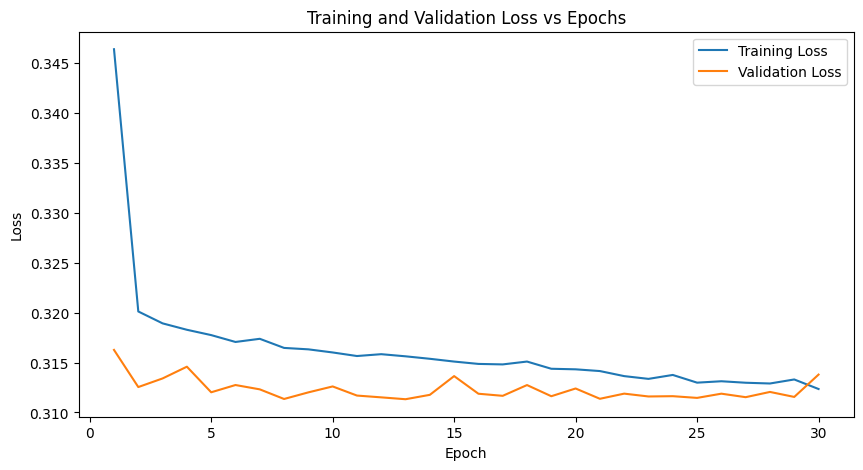

In [9]:
# Plotting training and validation loss vs epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(
plt.legend()
plt.show()

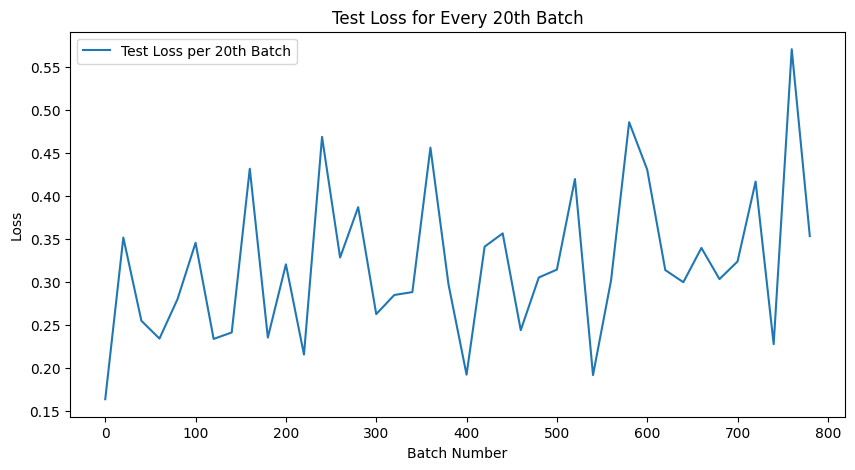

In [10]:
# Plotting test loss for every 20th batch
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(test_losses) * 20, 20), test_losses, label='Test Loss per 20th Batch')
plt.title('Test Loss for Every 20th Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()